In [1]:
# Load Modules
import os
if os.path.basename(os.getcwd()) == "illustration":
    os.chdir("..")
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
import datajoint as dj
import datetime
import spikeinterface as si
from spikeinterface import widgets, exporters, postprocessing, qualitymetrics, sorters
from workflow.pipeline import *
from workflow.utils.paths import (
    get_ephys_root_data_dir,
    get_raw_root_data_dir,
    get_processed_root_data_dir,
)
from element_interface.utils import dict_to_uuid, find_full_path, find_root_directory, _to_Path

import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import itertools
from workflow.utils.ingestion_utils import El2ROW
import probeinterface as pi
import random

# Parameters (Arbitrary and based on your computer)
file_dir = "/Users/judewerth/Library/CloudStorage/Box-Box/Organoid Data/Raw Data"
output_dir = "/Users/judewerth/Documents/Research/spikeinterface_output"

[2024-07-11 19:58:56,515][INFO]: Connecting judewerth@db.datajoint.com:3306
[2024-07-11 19:58:57,510][INFO]: Connected judewerth@db.datajoint.com:3306


In [53]:
def get_new_dir(dir):

    idx = 1

    new_dir = dir
    while new_dir.exists():

        new_dir = _to_Path(str(dir) + str(idx))
        idx +=1

    new_dir.mkdir(exist_ok=True, parents=True)
    
    return new_dir

In [54]:
def get_recording(files , spike_sorting_dir , file_dir , always_run=False):

    # Get Traces
    if (spike_sorting_dir / _to_Path("recording.pkl")).exists():

        recording = si.load_extractor(spike_sorting_dir / "recording.pkl")
        return recording

    stream_name = "RHD2000 amplifier channel"
    recording = None
    for file in [find_full_path(_to_Path(file_dir), f) for f in files]:
        print(f"Processing {file}.")
        if not recording:
            recording = si.extractors.read_intan(file, stream_name=stream_name)
        else:
            recording = si.concatenate_recordings(
                [recording, si.extractors.read_intan(file, stream_name=stream_name)]
        )

    recording.dump_to_pickle(file_path = spike_sorting_dir/"recording.pkl")

    return recording

In [55]:
def get_sorting(recording , spike_sorting_dir , always_run=False):

    sorter_name = "spykingcircus2"
    (spike_sorting_dir / sorter_name).mkdir(exist_ok=True, parents=True)

    if (spike_sorting_dir / "sorting.pkl").exists():

        sorting = si.load_extractor(spike_sorting_dir / "sorting.pkl")
        return sorting 


    sorting = si.sorters.run_sorter(
        recording=recording,
        folder=spike_sorting_dir/sorter_name,
        sorter_name=sorter_name,
        remove_existing_folder=True,
        verbose=True,
    )

    sorting.dump_to_pickle(file_path=spike_sorting_dir / "sorting.pkl")
    
    return sorting 

In [56]:
def get_waveforms(recording , sorting , spike_sorting_dir , always_run=False):

    if (spike_sorting_dir / "waveforms").exists():

        waveforms = si.load_waveforms(spike_sorting_dir / "waveforms", with_recording=True)
        return waveforms 


    waveforms = si.extract_waveforms(
        recording,
        sorting,
        folder=spike_sorting_dir / "waveforms",
        ms_before=1.5,
        ms_after=2.0,
        max_spikes_per_unit=500,
        # overwrite=True,
    )

    return waveforms 

In [5]:
def plot_traces(x , yvalues , labels , windowsize=100000 , title=None):

    fig , ax = plt.subplots(2,1)
    plt.subplots_adjust(hspace=.5)
    fig.set_figwidth(7)
    fig.set_figheight(5)
    
    if title is not None:
        ax[0].suptitle = title

    ax[0].set_title("Traces")
    for idx , y in enumerate(yvalues):
        ax[0].plot(x , y , label=labels[idx])

    
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("Voltage")
    ax[0].legend(loc="upper right")

    ax[1].set_title(f"Traces (random {windowsize/20000}s)")

    random_time = random.randint(0 , len(x)-windowsize)
    random_interval = [random_time , int(random_time+windowsize)]
    for idx , y in enumerate(yvalues):
        ax[1].plot(x[random_interval[0]:random_interval[1]] , y[random_interval[0]:random_interval[1]] , label=labels[idx])


    ax[1].set_xlabel("Time (s)")
    ax[1].set_ylabel("Voltage")
    

In [6]:
def plot_frequency_spectrum(f , Yvalues , labels , title=None):

    plt.figure()
    if title is not None:
        plt.title(title)

    for idx , Y in enumerate(Yvalues):  
        plt.plot(f[f>=0] , abs(Y[f>=0]) , label=labels[idx])


    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend(loc="lower left")

In [7]:
def filter_additive_noise(f , x , fband , inverse=False):

    minval = np.finfo(np.float32).eps

    # If noise is additive
    X = np.fft.fftshift(np.fft.fft(x)) # X = frequency domain of x , fftshift shifts the plot so it's centered at 0 Hz

    Xfilter = np.ones(len(x))
    Xfilter[abs(f) < fband[0]] = minval
    Xfilter[abs(f) > fband[1]] = minval

    if inverse:
        Xfilter = -Xfilter + 1

    X_filt = X * Xfilter

    x_filt = np.fft.ifft(np.fft.ifftshift(X_filt))
    x_filt = np.real(x_filt)

    return x_filt , X_filt

In [8]:
def filter_multiplicative_noise(f , x , fband , inverse=False):

    minval = np.finfo(np.float32).eps
    
    x[x==0] = minval # log can't divide by 0
    lnx = np.log(x.astype(complex)) # now log can deal with negatives

    lnX = np.fft.fftshift(np.fft.fft(lnx)) # DFT

    Xfilter = np.ones(len(x))
    Xfilter[abs(f) < fband[0]] = minval
    Xfilter[abs(f) > fband[1]] = minval

    if inverse:
        Xfilter = -Xfilter + 1

    lnX_filt = lnX * Xfilter

    lnx_filt = np.fft.ifft(np.fft.ifftshift(lnX_filt)) # bring back to time domain
    x_filt = np.real(np.exp(lnx_filt)) # undo log

    # find frequency spectra values
    X_filt = np.fft.fftshift(np.fft.fft(x_filt))

    return x_filt , X_filt , lnX , lnX_filt

In [9]:
def filter_convolved_noise(f , x , fband , inverse=False):

    minval = np.finfo(np.float32).eps
    
    # Check if noise is convoluted
    # DFT
    X = np.fft.fft(x) 
    # Unwrap
    X_mag = np.abs(X)
    X_phase = np.angle(X)
    # Log
    X_mag[X_mag==0] = minval
    lnX_mag = np.log(X_mag)
    # Inverse Fourier
    xq = np.fft.fftshift(np.fft.ifft(lnX_mag))
    # Filter (trial and error)
    Qfilter = np.ones(len(xq))
    Qfilter[abs(f) < fband[0]] = minval # lowpass
    Qfilter[abs(f) > fband[1]] = minval # lowpass

    if inverse:
        Qfilter = -Qfilter + 1
    xq_filt = xq * Qfilter

    # Start to invert everything and get filtered single
    # DFT
    Xq_filt = np.fft.fft(np.fft.ifftshift(xq_filt))
    # Inverse Log --> exp
    Xfilt_mag = np.abs(np.exp(Xq_filt)) # Idk if abs is needed
    # Rewrap phase
    Xfilt = Xfilt_mag * np.exp(1j * X_phase)
    # Inverse Fouerier
    x_filt = np.real(np.fft.ifft(Xfilt))
    # Get frequency spectra
    X_filt = np.fft.fftshift(np.fft.fft(x_filt))

    return x_filt , X_filt, xq , xq_filt

In [10]:
# Define Dictionaries
# Doing all Drug Treatments for the Tesst Organoids

Batches = ["Batch 1" , "Batch 2" , "Batch 3"]
Drugs = ["4-AP" , "No Drug" , "Bicuculline" , "Tetrodotoxin"]
Organoids = {
    "Batch 1":["O09" , "O10" , "O11" , "O12"],
    "Batch 2":["O13" , "O14" , "O15" , "O16"],
    "Batch 3":["O17" , "O18" , "O19" , "O20"]
}

used_electrodes = {
                "O09":32 , "O10":16 , "O11":20 , "O12":14 , 
                "O13":25 , "O14":13 , "O15":11 , "O16":11 ,
                "O17":22 , "O18":19 , "O19":20 , "O20":17
                }

session_times = {} # middle of each 5 minute interval
session_times["Batch 1"] = {}
session_times["Batch 2"] = {}
session_times["Batch 3"] = {}

# Batch 1
session_times["Batch 1"]["O09_4-AP"] = datetime.datetime(2023 , 5 , 18 , 12 , 54)
session_times["Batch 1"]["O10_4-AP"] = datetime.datetime(2023 , 5 , 18 , 12 , 56)
session_times["Batch 1"]["O11_4-AP"] = datetime.datetime(2023 , 5 , 18 , 12 , 56)
session_times["Batch 1"]["O12_4-AP"] = datetime.datetime(2023 , 5 , 18 , 12 , 54)

session_times["Batch 1"]["O09_No Drug"] = datetime.datetime(2023 , 5 , 18 , 18 , 46)
session_times["Batch 1"]["O10_No Drug"] = datetime.datetime(2023 , 5 , 18 , 18 , 42)
session_times["Batch 1"]["O11_No Drug"] = datetime.datetime(2023 , 5 , 18 , 18 , 46)
session_times["Batch 1"]["O12_No Drug"] = datetime.datetime(2023 , 5 , 18 , 18 , 44)

session_times["Batch 1"]["O09_Bicuculline"] = datetime.datetime(2023 , 5 , 19 , 10 , 2)
session_times["Batch 1"]["O10_Bicuculline"] = datetime.datetime(2023 , 5 , 19 , 10 , 1)
session_times["Batch 1"]["O11_Bicuculline"] = datetime.datetime(2023 , 5 , 19 , 10 , 4)
session_times["Batch 1"]["O12_Bicuculline"] = datetime.datetime(2023 , 5 , 19 , 9 , 59)

session_times["Batch 1"]["O09_Tetrodotoxin"] = datetime.datetime(2023 , 5 , 19 , 16 , 16)
session_times["Batch 1"]["O10_Tetrodotoxin"] = datetime.datetime(2023 , 5 , 19 , 16 , 12)
session_times["Batch 1"]["O11_Tetrodotoxin"] = datetime.datetime(2023 , 5 , 19 , 16 , 17)
session_times["Batch 1"]["O12_Tetrodotoxin"] = datetime.datetime(2023 , 5 , 19 , 16 , 15)

# Batch 2
session_times["Batch 2"]["O13_4-AP"] = datetime.datetime(2023 , 6 , 8 , 19 , 33)
session_times["Batch 2"]["O14_4-AP"] = datetime.datetime(2023 , 6 , 8 , 19 , 24)
session_times["Batch 2"]["O15_4-AP"] = datetime.datetime(2023 , 6 , 8 , 19 , 26)
session_times["Batch 2"]["O16_4-AP"] = datetime.datetime(2023 , 6 , 8 , 19 , 27)

session_times["Batch 2"]["O13_No Drug"] = datetime.datetime(2023 , 6 , 9 , 0 , 1)
session_times["Batch 2"]["O14_No Drug"] = datetime.datetime(2023 , 6 , 8 , 23 , 56)
session_times["Batch 2"]["O15_No Drug"] = datetime.datetime(2023 , 6 , 9 , 0 , 1)
session_times["Batch 2"]["O16_No Drug"] = datetime.datetime(2023 , 6 , 9 , 0 , 4)

session_times["Batch 2"]["O13_Bicuculline"] = datetime.datetime(2023 , 6 , 9 , 10 , 45)
session_times["Batch 2"]["O14_Bicuculline"] = datetime.datetime(2023 , 6 , 9 , 10 , 45)
session_times["Batch 2"]["O15_Bicuculline"] = datetime.datetime(2023 , 6 , 9 , 10 , 46)
session_times["Batch 2"]["O16_Bicuculline"] = datetime.datetime(2023 , 6 , 9 , 10 , 50)

session_times["Batch 2"]["O13_Tetrodotoxin"] = datetime.datetime(2023 , 6 , 9 , 16 , 4)
session_times["Batch 2"]["O14_Tetrodotoxin"] = datetime.datetime(2023 , 6 , 9 , 16 , 4)
session_times["Batch 2"]["O15_Tetrodotoxin"] = datetime.datetime(2023 , 6 , 9 , 16 , 13)
session_times["Batch 2"]["O16_Tetrodotoxin"] = datetime.datetime(2023 , 6 , 9 , 16 , 7)

# Batch 3
session_times["Batch 3"]["O17_4-AP"] = datetime.datetime(2023 , 7 , 12 , 13 , 32)
session_times["Batch 3"]["O18_4-AP"] = datetime.datetime(2023 , 7 , 12 , 13 , 31)
session_times["Batch 3"]["O19_4-AP"] = datetime.datetime(2023 , 7 , 12 , 13 , 34)
session_times["Batch 3"]["O20_4-AP"] = datetime.datetime(2023 , 7 , 12 , 13 , 34)

session_times["Batch 3"]["O17_No Drug"] = datetime.datetime(2023 , 7 , 12 , 16 , 32)
session_times["Batch 3"]["O18_No Drug"] = datetime.datetime(2023 , 7 , 12 , 16 , 37)
session_times["Batch 3"]["O19_No Drug"] = datetime.datetime(2023 , 7 , 12 , 16 , 34)
session_times["Batch 3"]["O20_No Drug"] = datetime.datetime(2023 , 7 , 12 , 16 , 43)

session_times["Batch 3"]["O17_Bicuculline"] = datetime.datetime(2023 , 7 , 13 , 12 , 58)
session_times["Batch 3"]["O18_Bicuculline"] = datetime.datetime(2023 , 7 , 13 , 13 , 8)
session_times["Batch 3"]["O19_Bicuculline"] = datetime.datetime(2023 , 7 , 13 , 13 , 2)
session_times["Batch 3"]["O20_Bicuculline"] = datetime.datetime(2023 , 7 , 13 , 13 , 7)

session_times["Batch 3"]["O17_Tetrodotoxin"] = datetime.datetime(2023 , 7 , 13 , 18 , 36)
session_times["Batch 3"]["O18_Tetrodotoxin"] = datetime.datetime(2023 , 7 , 13 , 18 , 39)
session_times["Batch 3"]["O19_Tetrodotoxin"] = datetime.datetime(2023 , 7 , 13 , 18 , 41)
session_times["Batch 3"]["O20_Tetrodotoxin"] = datetime.datetime(2023 , 7 , 13 , 18 , 40)

In [11]:
# EXPLORE FILTERING OPTIONS

In [61]:
# Get session (For Filtering)

batch = "Batch 1"
drug = "No Drug"
organoid = "O10" 
                  
# Find sesssion
time = session_times[batch][f"{organoid}_{drug}"].strftime("%Y-%m-%d %H:%M%")

# Get File Names
files, _ = ( 
    ephys.EphysRawFile
    & f"file_time LIKE '{time}'" # in this example, files is only 1 file (1 minute of data)
).fetch("file_path", "file_time", order_by="file_time")

# Adjust File Names (remove parent folder)
for idx , file in enumerate(files):
    files[idx] = file.split("/")[1]

# Get Spike Sorting Directory
title = time.replace(":" , ".")
spike_sorting_dir = _to_Path("/".join([output_dir , batch , drug , title , organoid]))
spike_sorting_dir.mkdir(exist_ok=True, parents=True)

print(files)
print(spike_sorting_dir)



['processed_O9-12_230518_184206.rhd']
/Users/judewerth/Documents/Research/spikeinterface_output/Batch 1/No Drug/2023-05-18 18.42%/O10


In [62]:
# Prepare Filtering

ch_id = 68 

# get recording
recording = get_recording(files=files , spike_sorting_dir=spike_sorting_dir , file_dir=file_dir)

# filter recording
recording_f = si.preprocessing.bandpass_filter(
    recording=recording, freq_min=300, freq_max=4500
)
recording_filt = si.preprocessing.common_reference(
    recording=recording_f, operator="median"
)

# get traces
# channel ids 0:31=O17 , 32:63=O18 , 64:95=O19 , 96:127=O20
channel_id = [recording.get_channel_ids()[ch_id]] # 50 is arbitrary
trace_raw = recording.get_traces(return_scaled=True , channel_ids=channel_id).flatten()
trace_filt = recording_filt.get_traces(return_scaled=True , channel_ids=channel_id).flatten()

x = trace_raw
X = np.fft.fftshift(np.fft.fft(x))

fs = recording.get_sampling_frequency()
f0 = 300
f1 = 4500 # same as recording --> recording_filt
fband = [f0,4500]

# global
dt = 1/fs
N = len(x)

# time
t = np.arange(1 , N+1) * dt

# frequency 
f = np.fft.fftshift(np.fft.fftfreq(len(x), 1/fs)) # corresponding frequencies

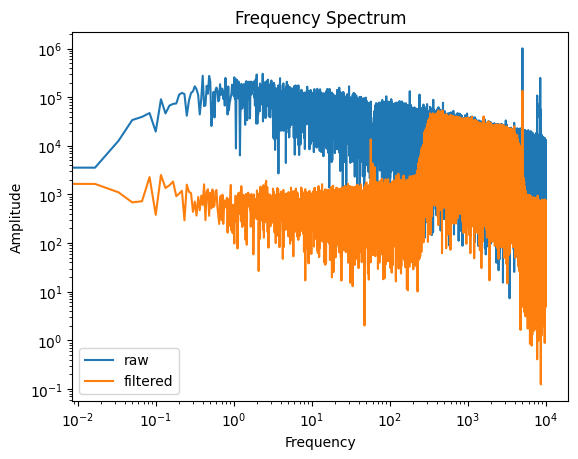

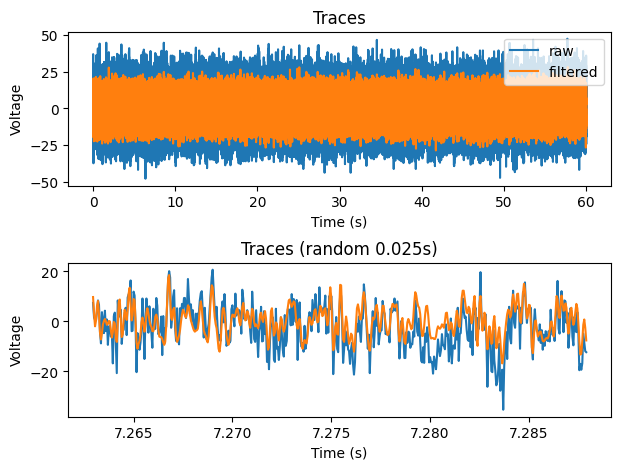

In [63]:
# Plot Traces and Spike Interface Filters

fs = recording.get_sampling_frequency()

t = np.arange(len(trace_raw)) / fs

X = np.fft.fftshift(np.fft.fft(trace_raw))
X_sifilt = np.fft.fftshift(np.fft.fft(trace_filt))

plot_frequency_spectrum(f , [X,X_sifilt] , ["raw","filtered"] , title="Frequency Spectrum")

plot_traces(t , [trace_raw , trace_filt] , ["raw" , "filtered"] , windowsize=500)



1.5043561208048077


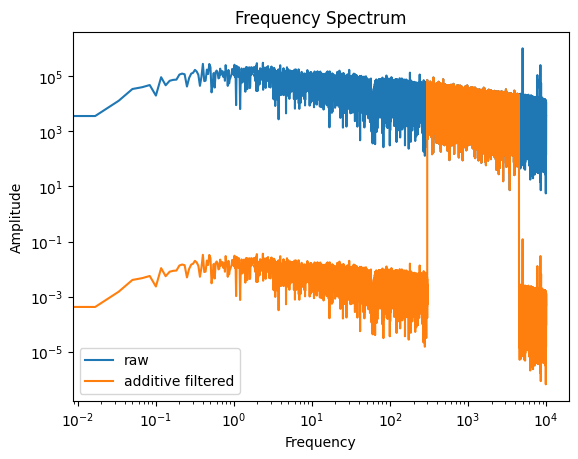

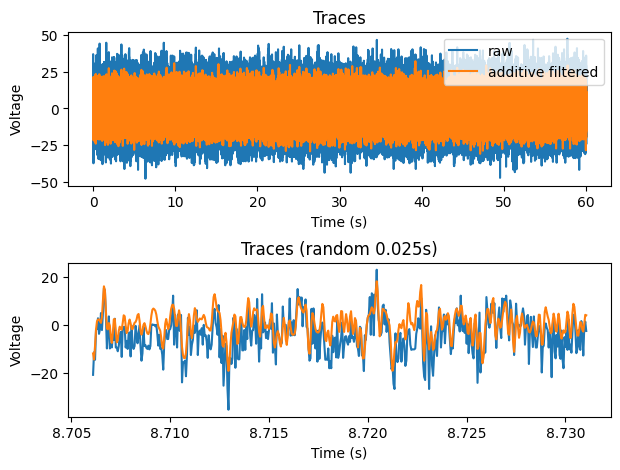

In [64]:
# Filter for Additive Noise
x_afilt , X_afilt = filter_additive_noise(f , x , fband)

plot_frequency_spectrum(f=f , Yvalues=[X,X_afilt] , labels=["raw" , "additive filtered"] , title="Frequency Spectrum")

norm = np.mean(abs(x))/np.mean(abs(x_afilt))
plot_traces(t , [x,x_afilt] , labels=["raw" , "additive filtered"] , windowsize=500)
print(norm)


1.5257408744518821


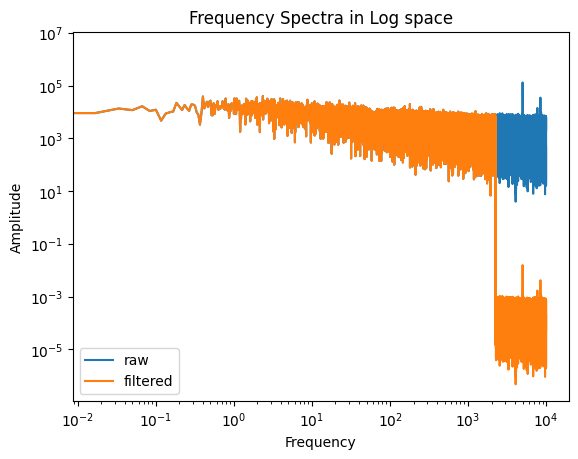

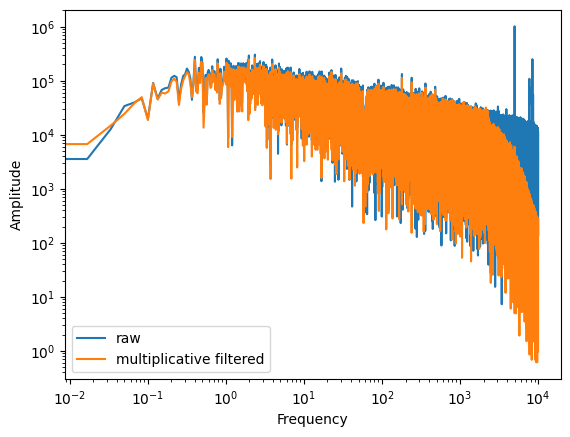

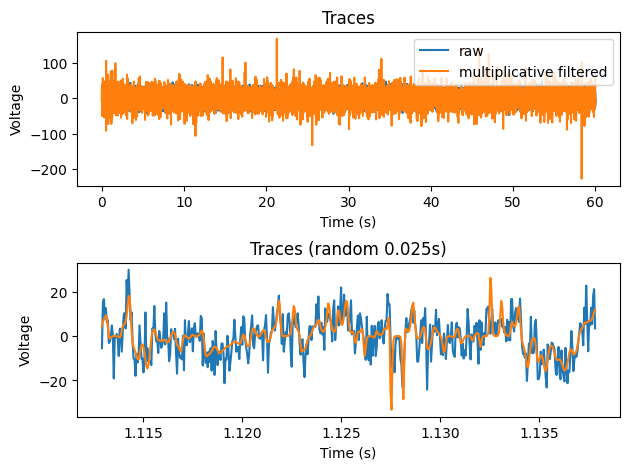

In [82]:
# Filter for Multiplicative Noise
x_mfilt , X_mfilt , lnX , lnX_filt = filter_multiplicative_noise(f , x , [0,2250])

plot_frequency_spectrum(f , [lnX,lnX_filt] , labels = ["raw","filtered"] , title="Frequency Spectra in Log space")
plot_frequency_spectrum(f , [X,X_mfilt] , labels=["raw","multiplicative filtered"])

norm = np.mean(abs(x))/np.mean(abs(x_mfilt))
plot_traces(t , [x,x_mfilt] , labels=["raw","multiplicative filtered"] , windowsize=500)
print(norm)



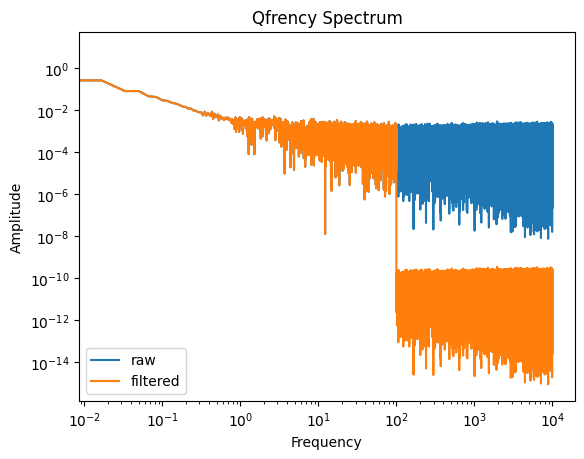

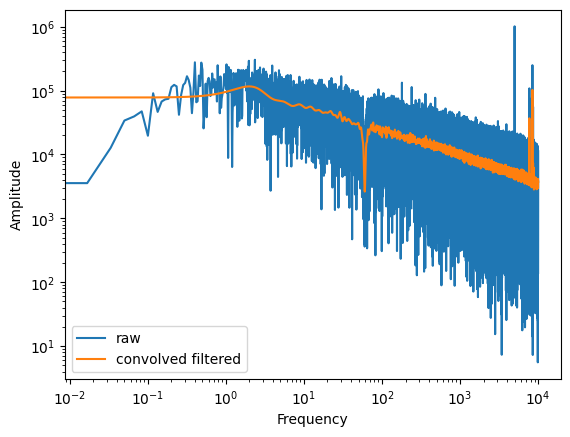

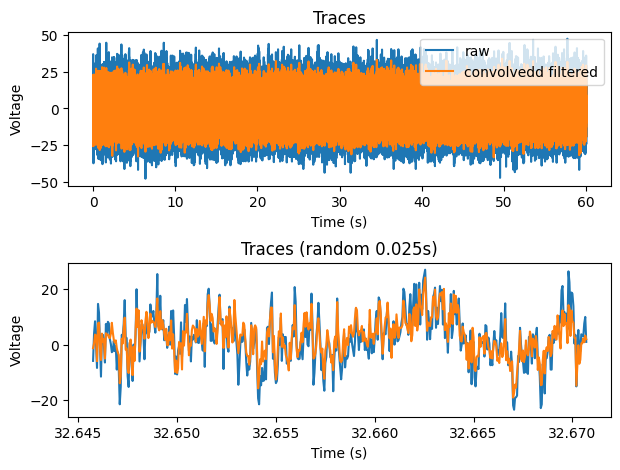

In [66]:
# Filter for Convolved Noise
x_cfilt , X_cfilt , xq , xq_filt = filter_convolved_noise(f , x , [0,100])

plot_frequency_spectrum(f , [xq,xq_filt] , labels=["raw","filtered"] , title="Qfrency Spectrum")
plot_frequency_spectrum(f , [X,X_cfilt] , labels=["raw","convolved filtered"])


plot_traces(t , [x,x_cfilt] , labels=["raw","convolvedd filtered"] , windowsize=500)

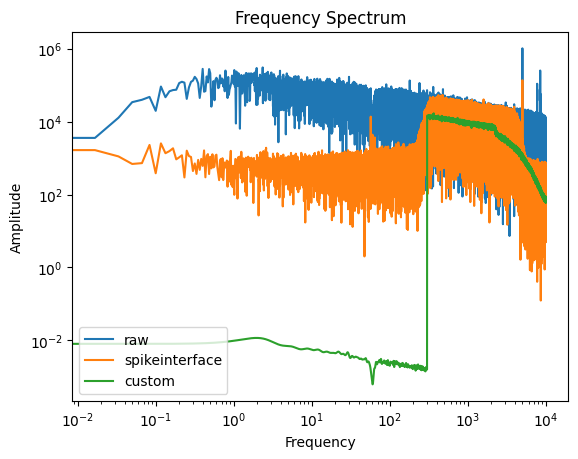

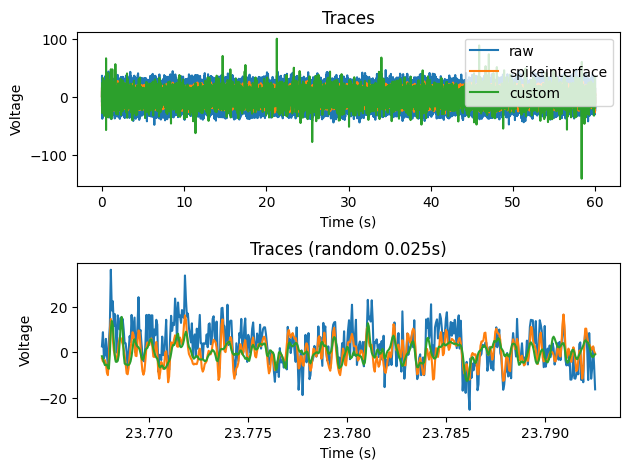

In [83]:
# Add Addtiive Filter to Convolved Filter

x1 , X1 , _ , _ = filter_multiplicative_noise(f , x , [0,2250])
x2 , X2 , _ , _ = filter_convolved_noise(f , x1 , [0 , 100])
x3 , X3 = filter_additive_noise(f , x2 , [300 , 80000])

plot_frequency_spectrum(f=f , Yvalues=[X,X_sifilt,X3] , labels=["raw","spikeinterface","custom"] , title="Frequency Spectrum")
plot_traces(t , [x,trace_filt,x3] , labels=["raw","spikeinterface","custom"] , windowsize=500)

In [19]:
# GET RECORDING AND SORTING INFORMATION

In [121]:
# Get session

batch = "Batch 2"
drug = "No Drug"
organoid = "O15"
electrodes = "outside"

channel_range = { # check this
    "Batch 1" : {"O09":(0,32),"O10":(32,64),"O11":(64,96),"O12":(96,128)},
    "Batch 2" : {"O13":(0,32),"O14":(32,64),"O15":(64,96),"O16":(96,128)},
    "Batch 3" : {"O17":(0,32),"O18":(32,64),"O19":(64,96),"O20":(96,128)}
}
chr = channel_range[batch][organoid]

if electrodes == "inside":
    channels = np.arange(chr[0],chr[1])[El2ROW[:used_electrodes[organoid]]]
    num_channels = used_electrodes[organoid]
    print(f"there are {num_channels} electrodes in the organoid which are {channels} (the organoid channel range is {channel_range[batch][organoid]})")
elif electrodes == "outside":
    channels = np.arange(chr[0],chr[1])[El2ROW[used_electrodes[organoid]:]]
    num_channels = 32 - used_electrodes[organoid]
    print(f"there are {num_channels} electrodes outside of the organoid which are {channels} (the organoid channel range is {channel_range[batch][organoid]})")
# Find sesssion
time = session_times[batch][f"{organoid}_{drug}"]
time = time.strftime('%Y-%m-%d %H:%M%')
# Get File Names
files, _ = ( 
    ephys.EphysRawFile
    & f"file_time LIKE '{time}'" # in this example, files is only 1 file (1 minute of data)
).fetch("file_path", "file_time", order_by="file_time")

# Adjust File Names (remove parent folder)
for idx , file in enumerate(files):
    files[idx] = file.split("/")[1]

# Get Spike Sorting Directory
title = time.replace(":" , ".")
spike_sorting_dir = _to_Path("/".join([output_dir , batch , drug , title , organoid , electrodes]))
spike_sorting_dir.mkdir(exist_ok=True, parents=True)

print(files)
print(spike_sorting_dir)

there are 21 electrodes outside of the organoid which are [74 84 67 85 66 86 65 88 79 89 78 90 77 91 76 87 64 92 75 80 71] (the organoid channel range is (64, 96))
['processed_O13-16_230609_000142.rhd']
/Users/judewerth/Documents/Research/spikeinterface_output/Batch 2/No Drug/2023-06-09 00.01%/O15/outside


In [122]:
# if you want to run recording / sorting / waveforms no matter what
spike_sorting_dir = get_new_dir(spike_sorting_dir)
spike_sorting_dir

PosixPath('/Users/judewerth/Documents/Research/spikeinterface_output/Batch 2/No Drug/2023-06-09 00.01%/O15/outside1')

In [123]:
# USE CUSTOM FILTER
def custom_filter(f , x):

    x1 , _ , _ , _ = filter_multiplicative_noise(f , x , [0,2250])
    x2 , _ , _ , _ = filter_convolved_noise(f , x1 , [0 , 100])
    x3 , _ = filter_additive_noise(f , x2 , [300 , 80000])

    #x_filt , _ = filter_additive_noise(f , x_cfilt , [500 , 4500])

    x_filt = x3
    return x_filt

# Get customed filtered traces array 
raw_recording = get_recording(files=files , spike_sorting_dir=spike_sorting_dir , file_dir=file_dir)

fs = raw_recording.get_sampling_frequency()
N = raw_recording.get_num_frames()
f = np.fft.fftshift(np.fft.fftfreq(N, 1/fs)) # corresponding frequencies

trace_list = []
for ch in channels:
    
    # get trace for a single channel
    raw_trace = raw_recording.get_traces(return_scaled=True , channel_ids=[raw_recording.channel_ids[ch]]).flatten()

    # filter trace
    trace_filt = custom_filter(f , raw_trace)

    # append to global list
    trace_list.append(trace_filt)

trace_array = np.transpose(np.array(trace_list))

# get recording
recording_filt = si.extractors.NumpyRecording(traces_list=trace_array , sampling_frequency=fs,channel_ids=list(raw_recording.channel_ids[channels]))

# Assign Probe
linear_probe = pi.generate_linear_probe(
    num_elec=len(channels), ypitch=100, contact_shape_params={"radius": 15}
)
linear_probe.set_device_channel_indices(list(range(len(channels))))
recording_filt = recording_filt.set_probe(linear_probe)

si.extractors.MdaRecordingExtractor.write_recording(recording_filt, spike_sorting_dir)
r = si.extractors.MdaRecordingExtractor(spike_sorting_dir)

r

Processing /Users/judewerth/Library/CloudStorage/Box-Box/Organoid Data/Raw Data/O13-16/processed_O13-16_230609_000142.rhd.


/Users/judewerth/anaconda3/envs/utah_organoids/lib/python3.9/site-packages/spikeinterface/core/job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


write_binary_recording:   0%|          | 0/60 [00:00<?, ?it/s]

MdaRecordingExtractor: 21 channels - 20.0kHz - 1 segments - 1,200,000 samples 
                       60.00s (1.00 minutes) - float32 dtype - 96.13 MiB

In [ ]:
# USE SPIKE INTERFACE FILTER
# Get Recording
raw_recording = get_recording(files=files , spike_sorting_dir=spike_sorting_dir , file_dir=file_dir)

# Filter Recording
recording_f = si.preprocessing.bandpass_filter(
    recording=raw_recording, freq_min=300, freq_max=4500
)
recording_filt = si.preprocessing.common_reference(
    recording=recording_f, operator="median"
)

# Assign Probe (I will be sorting all organoids at once)
linear_probe = pi.generate_linear_probe(
    num_elec=128, ypitch=100, contact_shape_params={"radius": 15}
)
linear_probe.set_device_channel_indices(list(range(128)))

recording = recording_filt.set_probe(linear_probe)

r = recording.channel_slice(channel_ids=list(recording.channel_ids[channels])) # Recording for defined organoid

In [124]:
# Get Sorting and Waveforms
s = get_sorting(recording=r , spike_sorting_dir=spike_sorting_dir , always_run=True)

w = get_waveforms(recording=r , sorting=s , spike_sorting_dir=spike_sorting_dir , )

we = si.create_sorting_analyzer(recording=r , sorting=s , folder=spike_sorting_dir/"waveforms sparse" , sparse=False)
random_spikes = we.compute("random_spikes")
waveforms = we.compute("waveforms" , ms_before=1.5 , ms_after=2)
templates = we.compute("templates")
noise_level = we.compute("noise_levels")


Geometry of the probe does not allow 1D drift correction


write_memory_recording:   0%|          | 0/60 [00:00<?, ?it/s]

detect peaks using locally_exclusive:   0%|          | 0/60 [00:00<?, ?it/s]

extract waveforms shared_memory mono buffer:   0%|          | 0/60 [00:00<?, ?it/s]

detect peaks using matched_filtering:   0%|          | 0/600 [00:00<?, ?it/s]

We found 25173 peaks in total
We kept 25173 peaks for clustering


extract waveforms shared_memory mono buffer:   0%|          | 0/60 [00:00<?, ?it/s]

extracting features:   0%|          | 0/60 [00:00<?, ?it/s]

split_clusters with local_feature_clustering:   0%|          | 0/21 [00:00<?, ?it/s]

estimate_templates:   0%|          | 0/60 [00:00<?, ?it/s]

We found 21 raw clusters, starting to clean with matching...


/Users/judewerth/anaconda3/envs/utah_organoids/lib/python3.9/site-packages/spikeinterface/core/job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


write_memory_recording:   0%|          | 0/1 [00:00<?, ?it/s]

We kept 21 non-duplicated clusters...


estimate_templates:   0%|          | 0/60 [00:00<?, ?it/s]

find spikes (wobble):   0%|          | 0/600 [00:00<?, ?it/s]

We found 20722 spikes
Final merging, keeping 21 units
spykingcircus2 run time 67.08s
####
# extract_waveforms() and WaveformExtractor() have been replaced by the `SortingAnalyzer` since version 0.101.0.
# You should use `spikeinterface.create_sorting_analyzer()` instead.
# `spikeinterface.extract_waveforms()` is now mocking the old behavior for backwards compatibility only,
# and will be removed with version 0.103.0
####


estimate_sparsity:   0%|          | 0/60 [00:00<?, ?it/s]

/Users/judewerth/anaconda3/envs/utah_organoids/lib/python3.9/site-packages/spikeinterface/core/basesorting.py:265: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


compute_waveforms:   0%|          | 0/60 [00:00<?, ?it/s]

compute_waveforms:   0%|          | 0/60 [00:00<?, ?it/s]

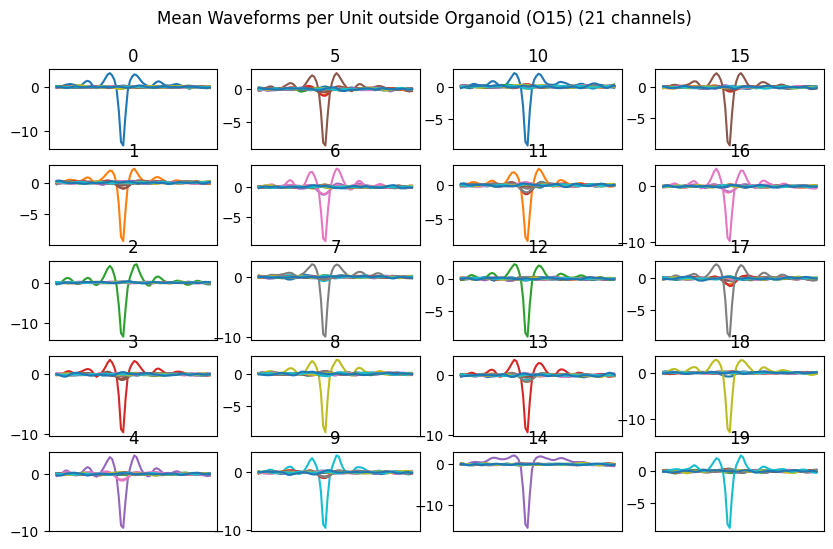

In [125]:
# Plot

temp_data = templates.get_data()
noise_levels = noise_level.get_data()

U,T,C = temp_data.shape

fig , ax = plt.subplots(nrows=5 , ncols=4, figsize =(10,6))
fig.suptitle(f"Mean Waveforms per Unit {electrodes} Organoid ({organoid}) ({num_channels} channels)")
x = 0
y = 0

# set number here
good_channels = noise_levels < 4


for i in range(min(U,20)):

    if (i%5 == 0) & (i!=0):
        x = 0
        y += 1

    template = temp_data[i,:,:]

    # filter channels
    # most_active_channels = np.max(abs(template),axis=0)
    # template = template[: , np.argpartition(most_active_channels , -3)[-3:]] # filters out all but 3 most active remaining channels

    # template = template[: , np.sum(template,axis=0) != 0] # if channel has no active
    # template = template[: , good_channels] # if channels have low noise levels
    # template = template[: , np.max(abs(template),axis=0) < 5] # if channels have a peak to low/high (set manually)

    ax[x,y].plot(template)
    ax[x,y].set_title(f'{i}')
    ax[x,y].set_xticks([])
    # ax[x,y].set_yticks([])

    x+=1

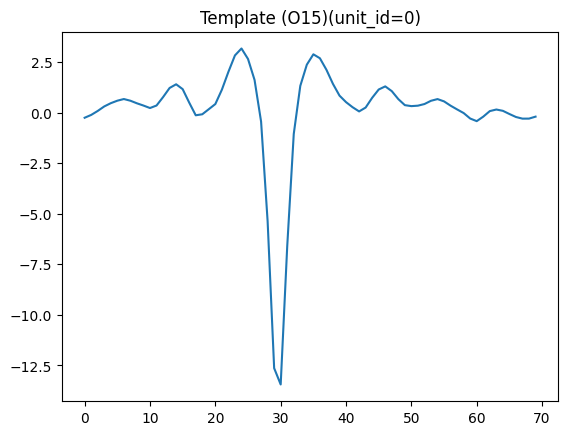

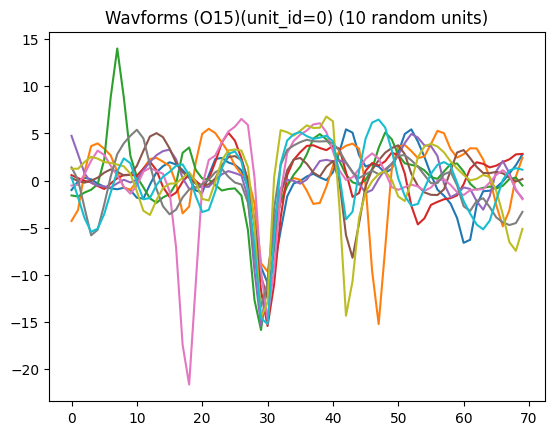

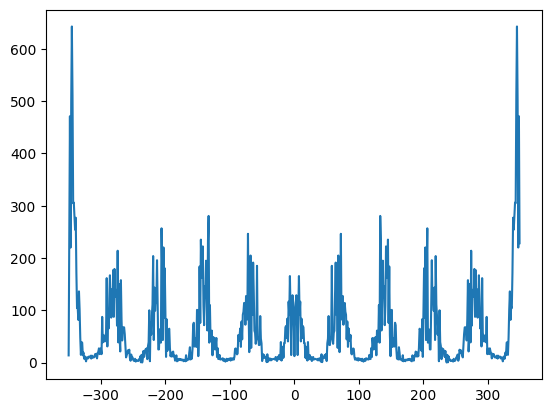

In [126]:
# Compare template to waveforms
unit_id = 0
num_we_plot = 10

template6 = templates.get_unit_template(unit_id=unit_id)
we6 = waveforms.get_waveforms_one_unit(unit_id=unit_id)

max_values = np.max(abs(template6),axis=0)
max_channel = max_values == np.sort(max_values)[-1]

max_channel_template6 = template6[: , max_channel].ravel()
max_channel_we6 = np.transpose(we6[:,: , max_channel].squeeze())

num_we = max_channel_we6.shape[1]
rand_we = np.random.randint(0 , num_we , size=num_we_plot)
max_channel_we6 = max_channel_we6[: , rand_we]

plt.figure
plt.plot(max_channel_template6)
plt.title(f"Template ({organoid})(unit_id={unit_id})")

plt.figure()
plt.plot(max_channel_we6)
plt.title(f"Wavforms ({organoid})(unit_id={unit_id}) ({num_we_plot} random units)")

plt.figure()
dft_max_channel = np.fft.fft(max_channel_we6.flatten())
plt.plot(np.arange(-int(len(dft_max_channel)/2),int(len(dft_max_channel)/2)) , abs(dft_max_channel))



In [ ]:
# INVESTIGATE FIRING RATES AND FREQUENCY SPECTRAA

20 Units detected


Text(0.5, 0, 'Time(s)')

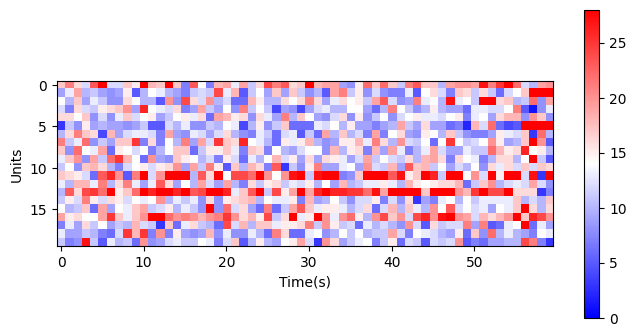

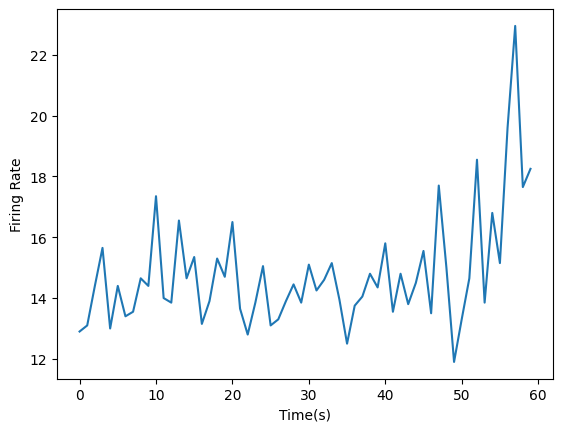

In [93]:
# Plot Firing Rate for Each Unit (Across the 1 minute)
fs = int(r.get_sampling_frequency())
N = int(r.get_num_samples())
time = np.arange(int(N/fs)+1)

spike_vector = s.to_spike_vector()
Units = np.unique(spike_vector["unit_index"]) # Find all units detected in recorded
print(f"{len(Units)} Units detected")

spike_times_list = []
for unit in Units:

    unit_spike_vector = spike_vector[spike_vector["unit_index"] == unit]
    unit_spike_samples = unit_spike_vector["sample_index"]
    unit_spike_times , sample_bins = np.histogram(unit_spike_samples , bins=time*fs) # bins = seconds (fs converts from s-->samples)

    spike_times_list.append(unit_spike_times)

spike_times_array = np.array(spike_times_list)

fig , ax = plt.subplots(figsize = (8,4))


plt.imshow(spike_times_array , cmap="bwr")
plt.colorbar()
plt.clim(vmin=0 , vmax=np.percentile(spike_times_array , 95))
plt.ylabel("Units")
plt.xlabel("Time(s)")

# From oberservation
unit_firing_rate = np.mean(spike_times_array , axis=1)
# Unit_idx 3-7 most prominent

time_firing_rate = np.mean(spike_times_array , axis=0)
plt.figure()
plt.plot(time_firing_rate)
plt.ylabel("Firing Rate")
plt.xlabel("Time(s)")


In [94]:
# Plot Frequency Spectra
# Define signal

# Parameters
fs = int(r.get_sampling_frequency())
N = int(r.get_num_samples())
time = np.arange(int(N/fs)+1)

# Get Signal (Using Channel 4(idx)) (arbitrary)
channel_id = r.get_channel_ids()[4]
rslice = r.channel_slice([channel_id])
signal = rslice.get_traces().flatten()

Text(0.5, 1.0, 'Frequency Amplitudes over Time')

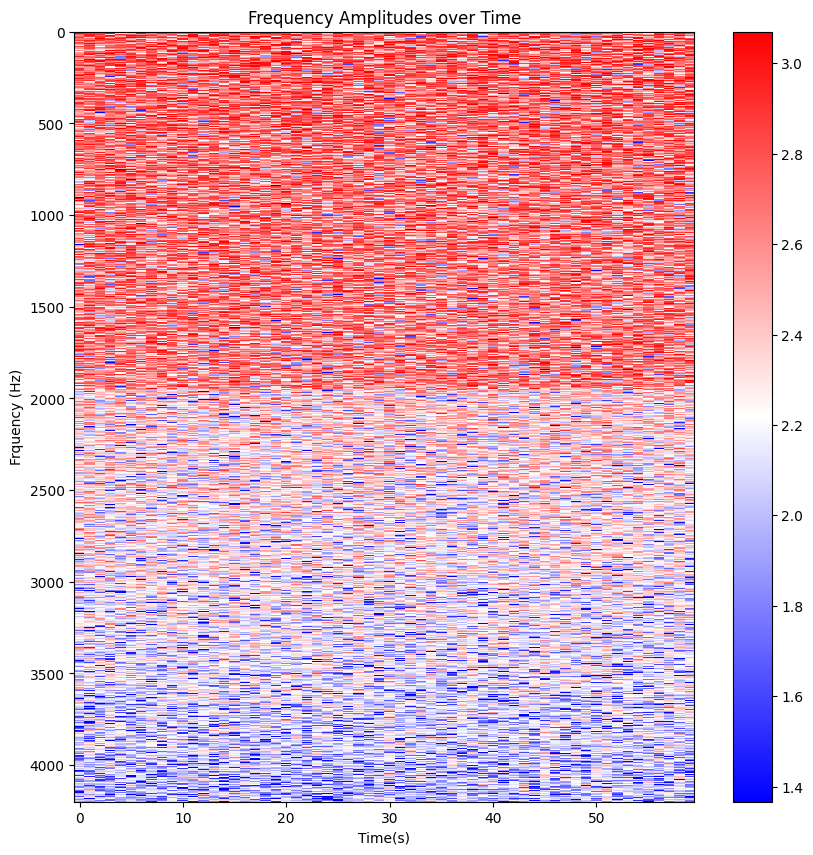

In [95]:
# Plot Spectra

freq_specra_list = []
for i in range(int(N/fs)):

    segments = np.arange(fs*i , fs*(i+1))
    signal_segment = signal[segments]

    fft_result = np.fft.fft(signal_segment) # DFT
    power_spectrum = np.log10(np.abs(fft_result)) # log of magnitude (assuming these are amplitudes)

    freq_specra_list.append(power_spectrum)

freq_specra_array = np.array(freq_specra_list)
freq_specra_array = freq_specra_array[:,300:4500] # Only count frequencies within bandpass filter

plt.figure(figsize=(10, 10))  # Set the figure size to be square
plt.imshow(np.transpose(freq_specra_array) , aspect='auto', interpolation='nearest' , cmap='bwr')
plt.colorbar()
plt.clim(vmin=np.percentile(freq_specra_array , 1) , vmax=np.percentile(freq_specra_array , 99))
plt.ylabel("Frquency (Hz)")
plt.xlabel("Time(s)")
plt.title("Frequency Amplitudes over Time")

